In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "4,5"
torch.cuda.device_count()

2

In [2]:
import transformers    

model = transformers.AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    use_auth_token=True,
    device_map="auto",
    offload_folder="./offload"
)

tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

from models.llama_7b import Llama

hooked_model = Llama(model, tokenizer)


/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.11s/it]


In [3]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
correct = 0
sum_logit_diff = 0
with torch.no_grad():
    for iter, batch in tqdm(enumerate(dataloader)):
        batch_tokens = batch["tokens"].cuda()
        
        logits = hooked_model.model(batch_tokens).logits.cpu()
        correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
        incorrect_logits = [
                [
                    tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                ]
                for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
            ]
        incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
        max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
        logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
        
        correct += (np.array(logit_diff) > 0).sum()
        sum_logit_diff += (np.array(logit_diff)).sum()
correct / len(tokenized_dataset), sum_logit_diff / len(tokenized_dataset)

Map: 100%|██████████| 408/408 [00:01<00:00, 246.69 examples/s] 
0it [00:00, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
204it [01:23,  2.44it/s]


(0.19852941176470587, -0.5385835415994128)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)
correct = 0
sum_logit_diff = 0
with torch.no_grad():
    for iter, batch in tqdm(enumerate(dataloader)):
        batch_tokens = batch["tokens"].cuda()
        
        logits = hooked_model.model(batch_tokens).logits.cpu()
        correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
        incorrect_logits = [
                [
                    tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                ]
                for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
            ]
        incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
        max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
        logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
        
        correct += (np.array(logit_diff) > 0).sum()
        sum_logit_diff += (np.array(logit_diff)).sum()
correct / len(tokenized_dataset), sum_logit_diff / len(tokenized_dataset)

409it [09:58,  1.46s/it]


(0.26560587515299877, -0.43834837093365675)

In [4]:
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)

Map: 100%|██████████| 818/818 [00:00<00:00, 1704.70 examples/s]


In [5]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import torch

accuracies = []
correct_activations = {(layer, head) : []
                       for layer in range(len(hooked_model.model.model.layers))
                       for head in range(hooked_model.model.model.layers[0].self_attn.num_heads)}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"]
        hooked_model.model(batch_tokens)

        for layer in range(len(hooked_model.model.model.layers)):
            for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
                correct_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                    np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                    ].detach().cpu())

for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        correct_activations_dataset = torch.vstack(correct_activations[(layer, head)])
        X = correct_activations_dataset.numpy()
        y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


In [6]:
accuracies_sorted = []
i = 0
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accuracies_sorted.append((-accuracies[i], layer, head))
        i += 1
accuracies_sorted = sorted(accuracies_sorted)

In [7]:
import json
# with open("cache/accuracies_sorted.json", "w") as file:
#     json.dump(accuracies_sorted, file)
with open("cache/accuracies_sorted.json", "r") as file:
    accuracies_sorted = json.load(file)

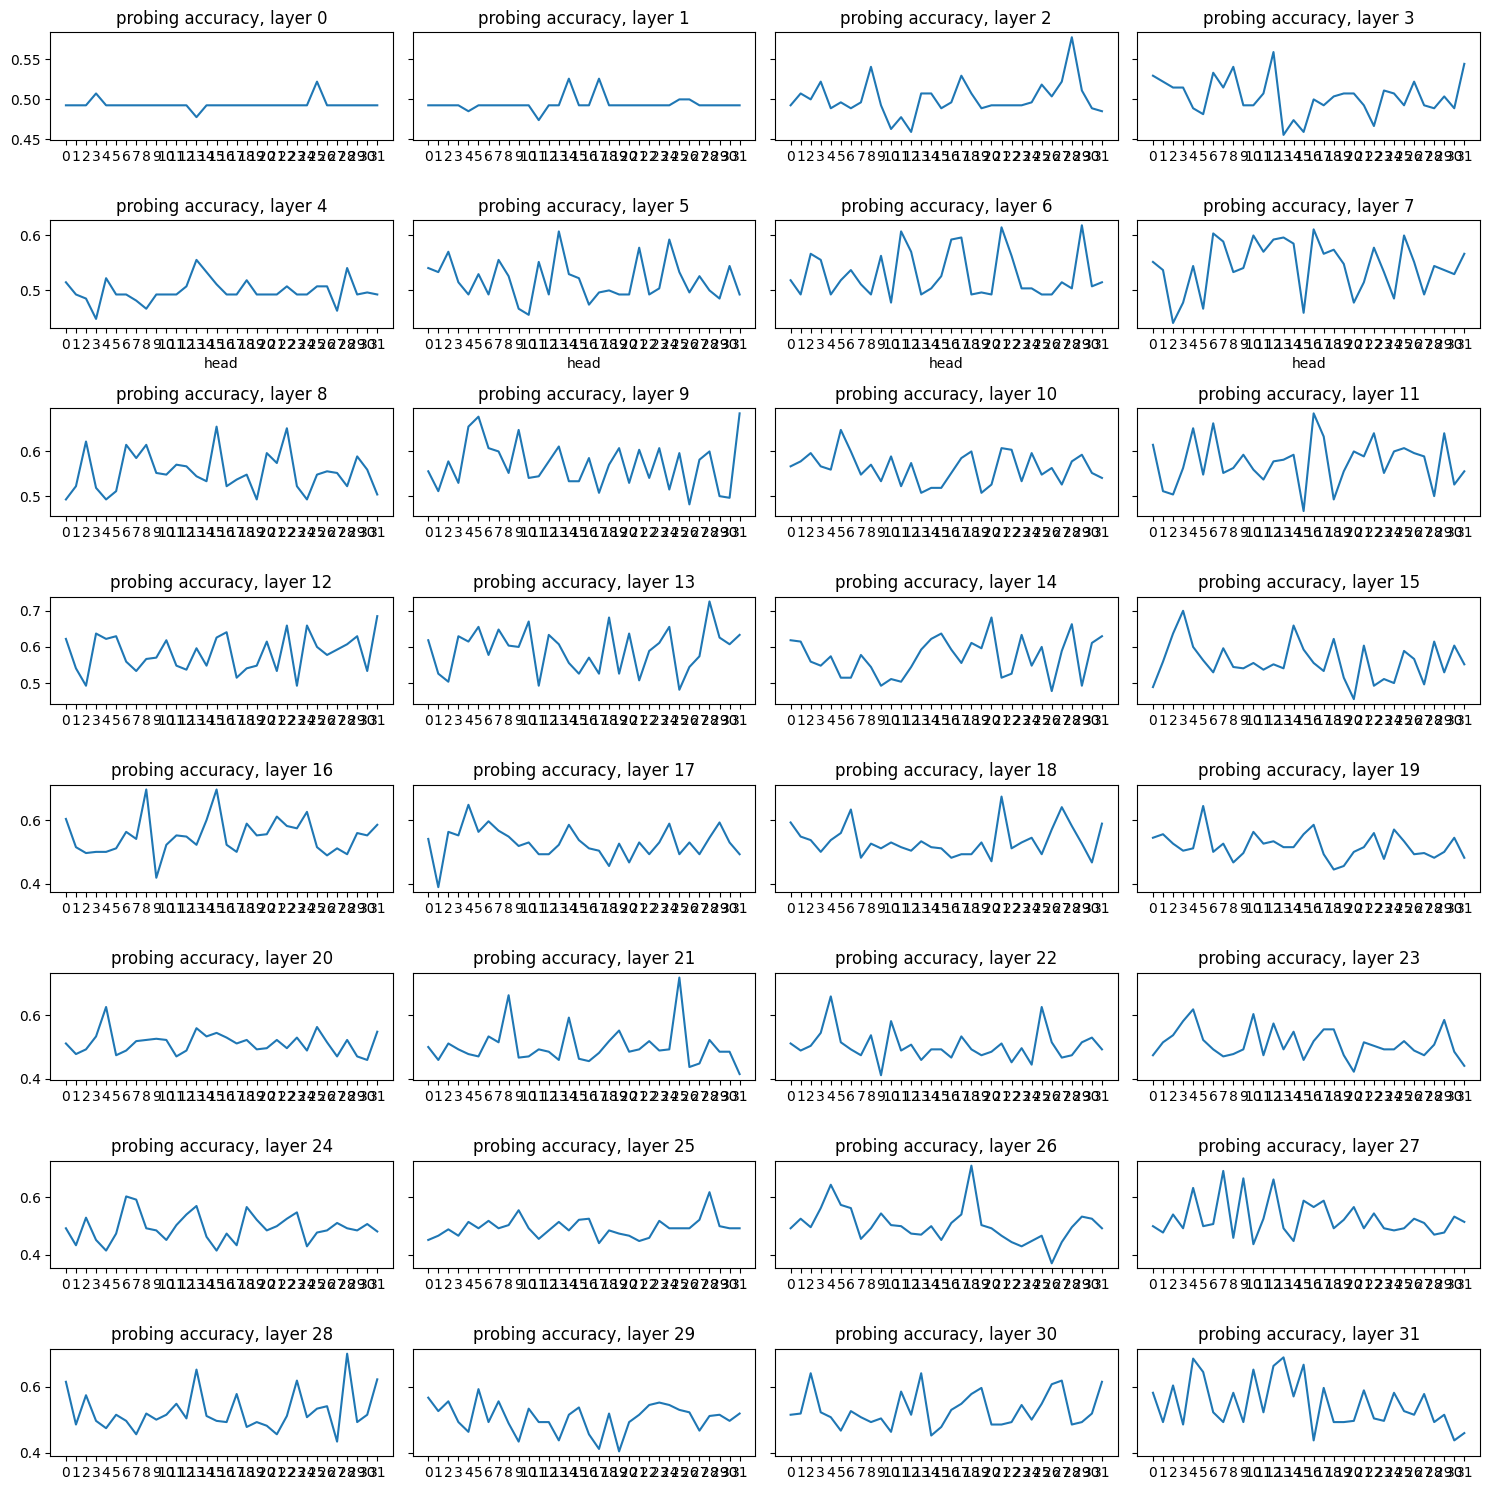

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict
i = 0
accs_by_layer = defaultdict(list)
for layer in range(len(hooked_model.model.model.layers)):
    for head in range(hooked_model.model.model.layers[0].self_attn.num_heads):
        accs_by_layer[layer].append(accuracies[i])
        i += 1
        
fig, axs = plt.subplots(8, 4, sharey="row")
fig.set_size_inches((15, 15))
for i, layer in enumerate(accs_by_layer):
    y = i // 4
    x = i % 4
    axs[y][x].plot(accs_by_layer[layer])
    axs[y][x].set_title(f"probing accuracy, layer {layer}")

for i in range(8):
    for j in range(4):
        axs[i][j].set_xticks(np.arange(len(accs_by_layer[0])), labels=np.arange(len(accs_by_layer[0])))
        if i == 1:
            axs[i][j].set_xlabel("head")
fig.tight_layout()
plt.savefig("images/probing_accuracies.png")

In [9]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)


steering_directions = {(layer, head): None for layer in range(32) for head in range(32)}
stds = {(layer, head): None for layer in range(32) for head in range(32)}

all_activations = {pos : [] for pos in steering_directions.keys()}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"]
        hooked_model.model(batch_tokens)

        for layer, head in steering_directions.keys():
            all_activations[(layer, head)].append(hooked_model.cache_activations[(layer, head)][
                np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :
                ].detach().cpu())

for layer, head in steering_directions.keys():
    all_activations_dataset = torch.vstack(all_activations[(layer, head)])
    X = all_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
    pos_activations = X[y == 1]
    neg_activations = X[y == -1]
    steering_directions[(layer, head)] = np.mean(pos_activations, axis=0) - np.mean(neg_activations, axis=0)
    direction_norm = np.linalg.norm(steering_directions[(layer, head)])
    stds[(layer, head)] = np.std(np.dot(X, steering_directions[(layer, head)]) / direction_norm)

100%|██████████| 409/409 [01:23<00:00,  4.92it/s]


In [10]:
# import json
# with open("cache/steering_directions.json", "w") as file:
#     json.dump({str(item): steering_directions[item].tolist() for item in steering_directions}, file)
# with open("cache/stds.json", "w") as file:
#     json.dump({str(item): stds[item].item() for item in stds}, file)
import numpy as np
import json
with open("cache/steering_directions.json", "r") as file:
    steering_directions_json = json.load(file)
steering_directions = {}
for item in steering_directions_json:
    steering_directions[eval(item)] = np.array(steering_directions_json[item])
with open("cache/stds.json", "r") as file:
    stds_json = json.load(file)
stds = {}
for item in stds_json:
    stds[eval(item)] = stds_json[item]

In [13]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
from collections import defaultdict

ks = [64, 80, 96]
alphas = [0, 20, 25, 30]

task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_datasets = []
for seed in [42, 0, 5, 10, 15]:
    tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=True, testing_split=False,
                                                random_seed=seed, subset_len=81, max_length=1000)
    tokenized_datasets.append(tokenized_dataset)

# accs_by_k_alpha = defaultdict(list)
# logit_diffs_by_k_alpha = defaultdict(list)
for k in ks:
    for alpha in alphas[1:]:
        for dataset_i in range(len(tokenized_datasets)):
            dataloader = DataLoader(tokenized_datasets[dataset_i], batch_size=2, shuffle=False)
            correct = 0
            sum_logit_diff = 0
            positions_to_steer = [(t[1], t[2], -1) for t in accuracies_sorted[:k]]
            vectors = [alpha * steering_directions[(pos[0], pos[1])] * stds[(pos[0], pos[1])] for pos in positions_to_steer]
            hooked_model.set_steering_vectors(vectors, positions_to_steer)
            with torch.no_grad():
                for iter, batch in tqdm(enumerate(dataloader)):
                    batch_tokens = batch["tokens"].cuda()
                    
                    logits = hooked_model.model(batch_tokens).logits.cpu()
                    correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
                    incorrect_logits = [
                            [
                                tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                            ]
                            for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
                        ]
                    incorrect_logits_probs = [np.array([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
                    max_incorrect_logit = [incorrect_logits[batch_i][np.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
                    logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
                
                    correct += (np.array(logit_diff) > 0).sum()
                    sum_logit_diff += (np.array(logit_diff)).sum()
            accs_by_k_alpha[(k, alpha)].append(correct / len(tokenized_dataset))
            logit_diffs_by_k_alpha[(k, alpha)].append(sum_logit_diff / len(tokenized_dataset))
            print(k, alpha, dataset_i, accs_by_k_alpha[(k, alpha)])

Map: 100%|██████████| 81/81 [00:00<00:00, 248.72 examples/s]
41it [00:21,  1.89it/s]


64 20 0 [0.24691358024691357]


41it [00:17,  2.36it/s]


64 20 1 [0.24691358024691357, 0.2345679012345679]


41it [00:15,  2.59it/s]


64 20 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:16,  2.52it/s]


64 20 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.18518518518518517]


41it [00:16,  2.55it/s]


64 20 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.18518518518518517, 0.19753086419753085]


41it [00:16,  2.46it/s]


64 25 0 [0.24691358024691357]


41it [00:16,  2.45it/s]


64 25 1 [0.24691358024691357, 0.2345679012345679]


41it [00:15,  2.64it/s]


64 25 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:15,  2.62it/s]


64 25 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085]


41it [00:16,  2.53it/s]


64 25 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085, 0.1728395061728395]


41it [00:16,  2.51it/s]


64 30 0 [0.24691358024691357]


41it [00:16,  2.48it/s]


64 30 1 [0.24691358024691357, 0.2345679012345679]


41it [00:15,  2.65it/s]


64 30 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:15,  2.57it/s]


64 30 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085]


41it [00:16,  2.45it/s]


64 30 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085, 0.1728395061728395]


41it [00:16,  2.47it/s]


80 20 0 [0.24691358024691357]


41it [00:17,  2.40it/s]


80 20 1 [0.24691358024691357, 0.2345679012345679]


41it [00:15,  2.61it/s]


80 20 2 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679]


41it [00:15,  2.62it/s]


80 20 3 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679, 0.18518518518518517]


41it [00:16,  2.56it/s]


80 20 4 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679, 0.18518518518518517, 0.18518518518518517]


41it [00:16,  2.52it/s]


80 25 0 [0.24691358024691357]


41it [00:16,  2.51it/s]


80 25 1 [0.24691358024691357, 0.2345679012345679]


41it [00:15,  2.67it/s]


80 25 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:15,  2.59it/s]


80 25 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085]


41it [00:16,  2.55it/s]


80 25 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085, 0.16049382716049382]


41it [00:21,  1.95it/s]


80 30 0 [0.24691358024691357]


41it [00:23,  1.74it/s]


80 30 1 [0.24691358024691357, 0.2345679012345679]


41it [00:17,  2.29it/s]


80 30 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:19,  2.05it/s]


80 30 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085]


41it [00:21,  1.88it/s]


80 30 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085, 0.1728395061728395]


41it [00:20,  2.00it/s]


96 20 0 [0.24691358024691357]


41it [00:22,  1.79it/s]


96 20 1 [0.24691358024691357, 0.25925925925925924]


41it [00:17,  2.28it/s]


96 20 2 [0.24691358024691357, 0.25925925925925924, 0.19753086419753085]


41it [00:19,  2.07it/s]


96 20 3 [0.24691358024691357, 0.25925925925925924, 0.19753086419753085, 0.18518518518518517]


41it [00:20,  1.96it/s]


96 20 4 [0.24691358024691357, 0.25925925925925924, 0.19753086419753085, 0.18518518518518517, 0.19753086419753085]


41it [00:21,  1.90it/s]


96 25 0 [0.24691358024691357]


41it [00:22,  1.78it/s]


96 25 1 [0.24691358024691357, 0.2345679012345679]


41it [00:18,  2.26it/s]


96 25 2 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222]


41it [00:19,  2.14it/s]


96 25 3 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085]


41it [00:21,  1.87it/s]


96 25 4 [0.24691358024691357, 0.2345679012345679, 0.2222222222222222, 0.19753086419753085, 0.19753086419753085]


41it [00:21,  1.91it/s]


96 30 0 [0.24691358024691357]


41it [00:22,  1.80it/s]


96 30 1 [0.24691358024691357, 0.2345679012345679]


41it [00:19,  2.15it/s]


96 30 2 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679]


41it [00:20,  2.05it/s]


96 30 3 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679, 0.19753086419753085]


41it [00:23,  1.73it/s]

96 30 4 [0.24691358024691357, 0.2345679012345679, 0.2345679012345679, 0.19753086419753085, 0.19753086419753085]


In [1]:
import json
# with open("cache/accs_by_k_alpha.json", "w") as file:
#     json.dump({str(k): str(a) for k, a in accs_by_k_alpha.items()}, file)
with open("cache/accs_by_k_alpha.json", "r") as file:
    accs_by_k_alpha_json = json.load(file)
accs_by_k_alpha = {}
for k, v in accs_by_k_alpha_json.items():
    accs_by_k_alpha[eval(k)] = eval(v)

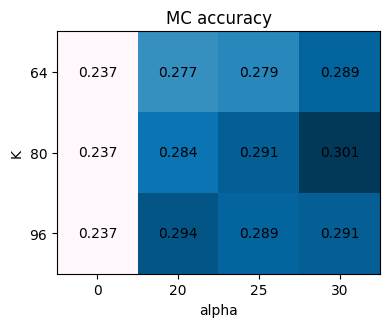

In [34]:
import numpy as np
with open("cache/accs_by_k_alpha_on_probing_data.json", "r") as file:
    accs_by_k_alpha_json = json.load(file)
accs_by_k_alpha = {}
for k, v in accs_by_k_alpha_json.items():
    accs_by_k_alpha[eval(k)] = eval(v)

ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))

with open("cache/accs_by_k_alpha_on_probing_data_no_invervention.json", "r") as file:
    accs_no_intervention_json = json.load(file)
for k in ks:
    accs_by_k_alpha[(k, 0)] = eval(accs_no_intervention_json)

# ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))
alphas = sorted(list(set([a for k, a in accs_by_k_alpha.keys()])))

a = np.zeros((len(ks), len(alphas)))
for k_i, k in enumerate(ks):
    for a_i, alpha in enumerate(alphas):
        a[k_i, a_i] = f"{np.mean(accs_by_k_alpha[(k, alpha)]).item():.3f}"


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((4, 4))
im = ax.imshow(a, cmap="PuBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(alphas)), labels=alphas)
ax.set_yticks(np.arange(len(ks)), labels=ks)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ks)):
    for j in range(len(alphas)):
        text = ax.text(j, i, a[i, j],
                       ha="center", va="center", color="black")

ax.set_title("MC accuracy")
ax.set_xlabel("alpha")
ax.set_ylabel("K")
fig.tight_layout()
plt.show()
plt.savefig("images/MC_acc_steering.png")

In [ ]:
test on 80 30:  0.23284313725490197 -0.13956496177935132